In [1]:
!pip install prophet

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2025-11-30 21:44:02--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2025-11-30 21:44:03 (40.6 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [3]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [5]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
df.columns = ['y']

In [7]:
df['ds'] = df.index

In [8]:
df.head()

,y,ds
Month,,
1949-01-01,112,1949-01-01
1949-02-01,118,1949-02-01
1949-03-01,132,1949-03-01
1949-04-01,129,1949-04-01
1949-05-01,121,1949-05-01


In [9]:
df.tail()

,y,ds
Month,,
1960-08-01,606,1960-08-01
1960-09-01,508,1960-09-01
1960-10-01,461,1960-10-01
1960-11-01,390,1960-11-01
1960-12-01,432,1960-12-01


In [10]:
m = Prophet()

In [11]:
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future = m.make_future_dataframe(periods=12, freq='MS') # will be making 1 year forecast

In [13]:
future.tail()

,ds
151,1961-08-01
152,1961-09-01
153,1961-10-01
154,1961-11-01
155,1961-12-01


In [14]:
forecast = m.predict(future)

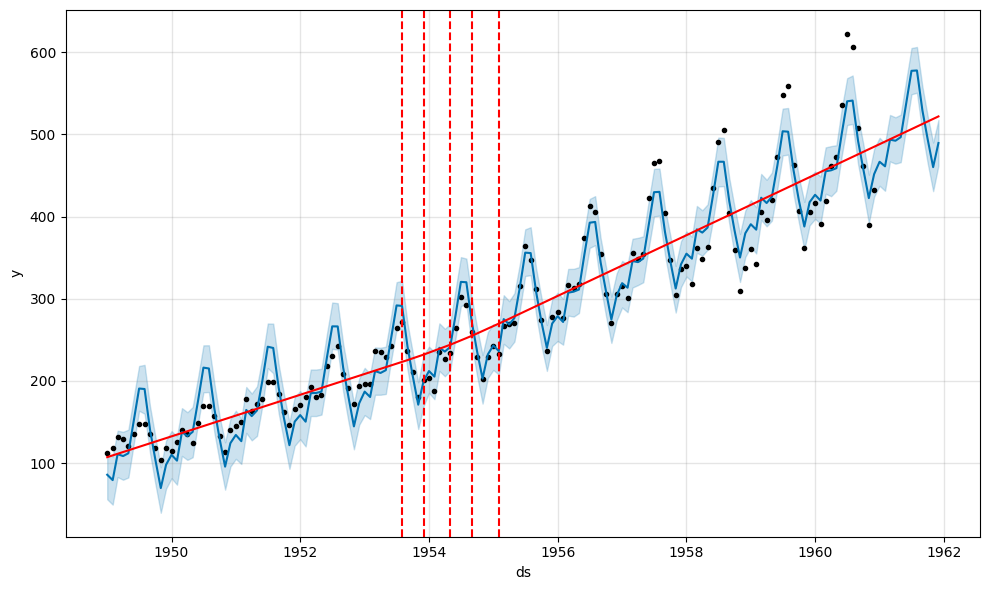

In [18]:
# overestimates at beginning and underestimates at end. It's unable to model the fact that seasonal component magnitude increases
# over time. This is because by default we have additive seasonality.
fig = m.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), m, forecast)

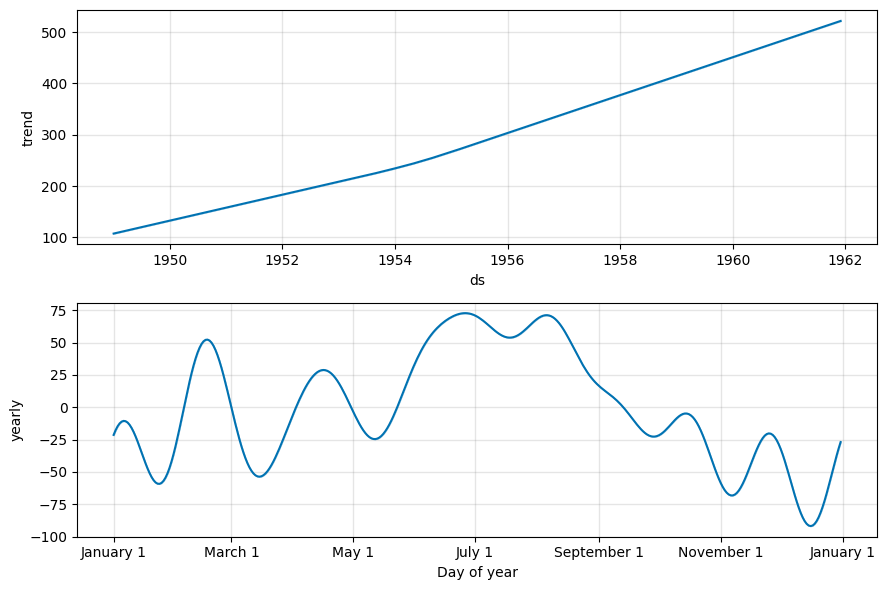

In [17]:
# note peakness in annual seasonality in airline passengers in summer months
m.plot_components(forecast);

In [19]:
m2 = Prophet(seasonality_mode='multiplicative')

In [20]:
m2.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
future = m2.make_future_dataframe(periods=12, freq='MS')

In [22]:
forecast = m2.predict(future)

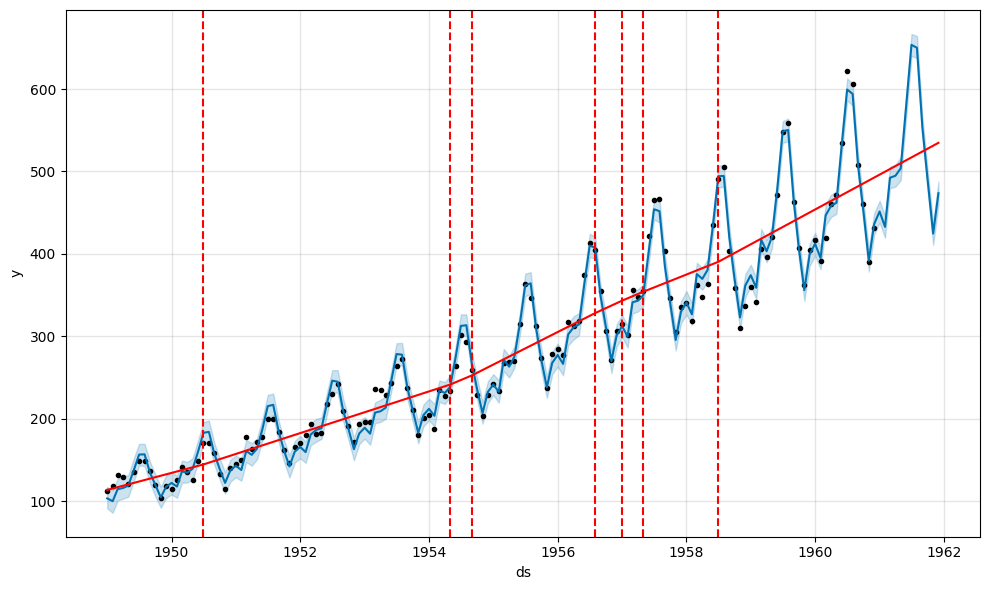

In [24]:
# does better job of matching peaks and troughs both when seasonal component is small and large
fig = m2.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), m2, forecast)

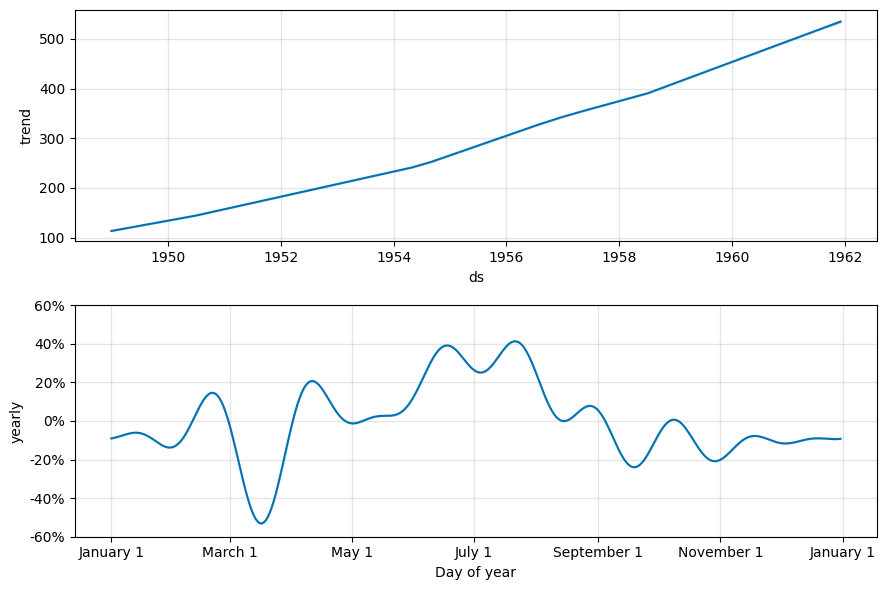

In [25]:
m2.plot_components(forecast);

In [29]:
# One way to avoid using multiplicative seasonality is to take log of data
# As a reminder, BOX COX TRANSFORMATION (x^lambda - 1)/lambda gives ln(x) when lambda -> 0
# When lambda->0 (x^lambda - 1)/lambda becomes 0/0 form and we can obtain limit using L'Hôpital's rule which is
# lambda->0 (x^lambda - 1)/lambda = lambda->0 (ln x) (x^lambda) = ln x
logdf = df.copy()
logdf['y'] = np.log(logdf['y'])

In [30]:
m3 = Prophet()

In [31]:
m3.fit(logdf)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future = m3.make_future_dataframe(periods=12, freq='MS')

In [33]:
forecast = m3.predict(future)

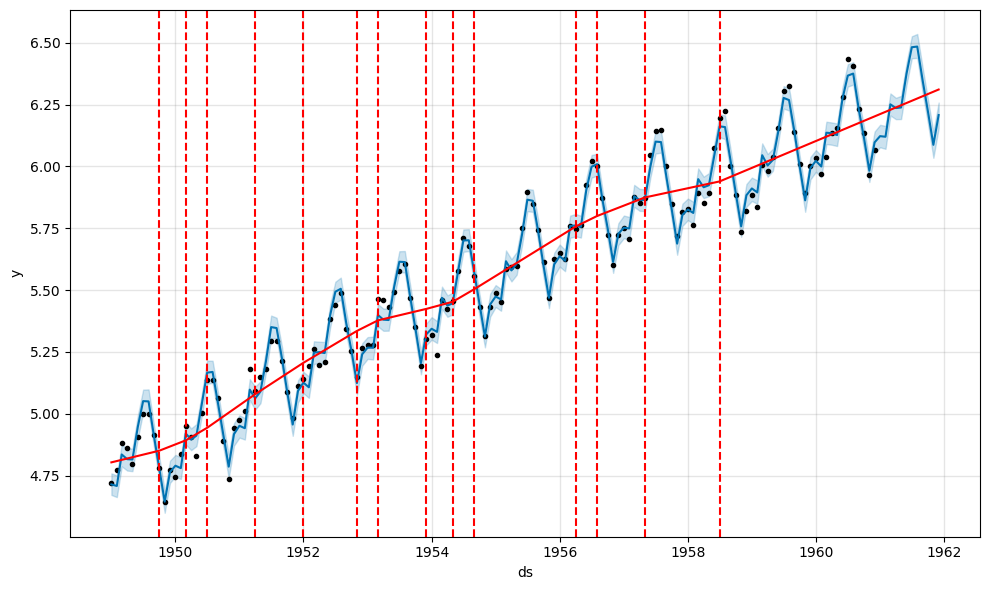

In [36]:
# bit too sensitive with change points but no issue with seasonal components thanks to log transform
fig = m3.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), m3, forecast)

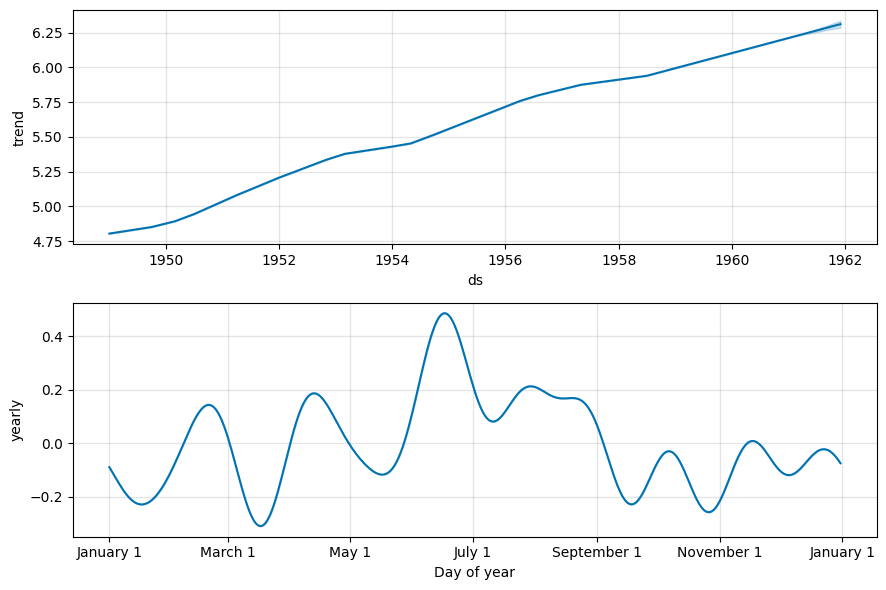

In [37]:
m3.plot_components(forecast);

In [ ]:
# Outliers

In [38]:
df.loc['1955-01-01', 'y'] = 600
df.loc['1957-06-01', 'y'] = 1

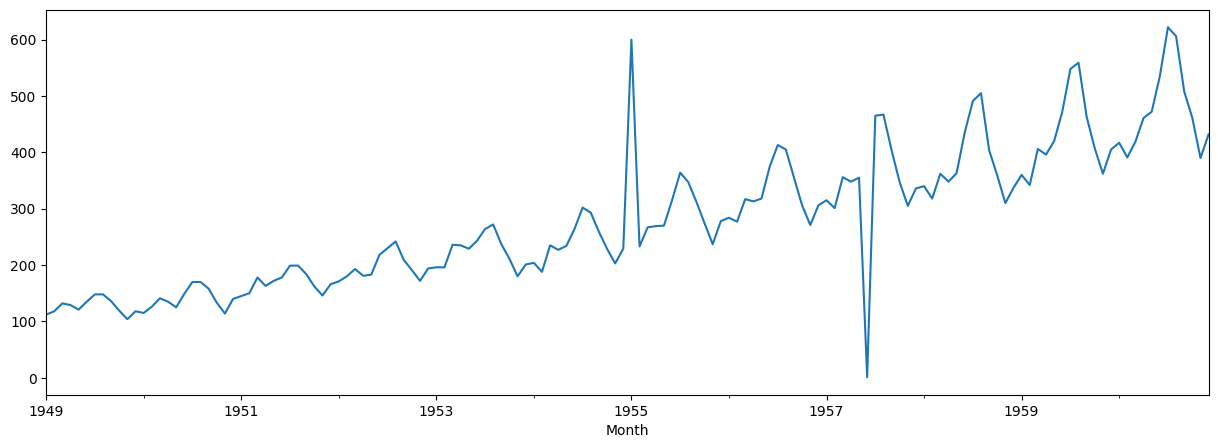

In [39]:
df['y'].plot(figsize=(15, 5));

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


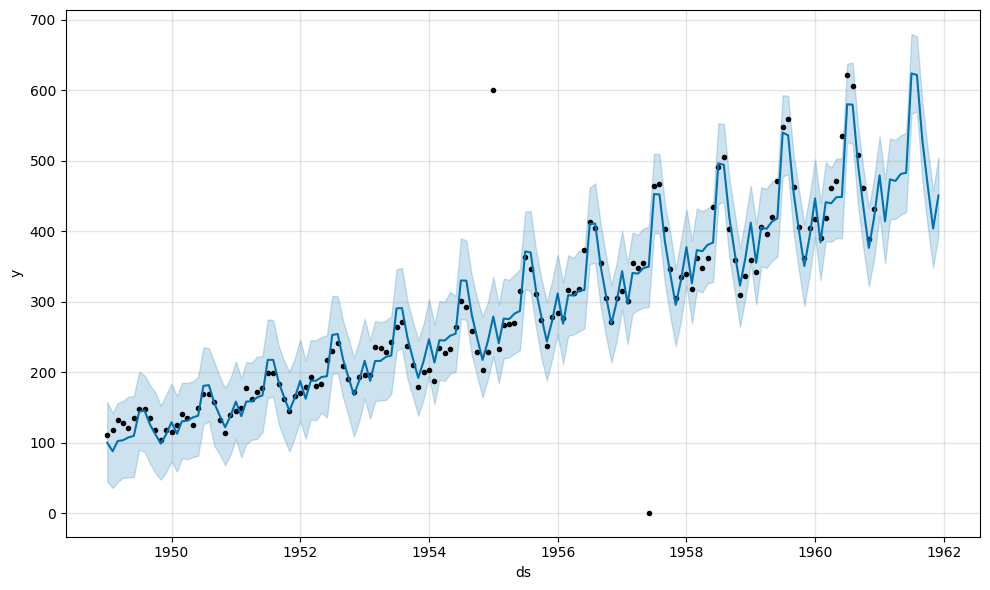

In [40]:
# prediction interval is large compared to what it was before due to outliers. If model has seen outliers, it may expect to
# see them again in future making it less confident in its own predictions
m = Prophet(seasonality_mode='multiplicative')
m.fit(df)
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)
m.plot(forecast); # wide confidence interval

In [41]:
# Prophet is continuous time model and time is the only regressor, so missing data is a non-issue. Hence recommended method to deal
# with outliers is to simply remove them
df2 = df[~df.index.isin(['1955-01-01', '1957-06-01'])]

/tmp/ipython-input-673382372.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df2 = df[~df.index.isin(['1955-01-01', '1957-06-01'])]


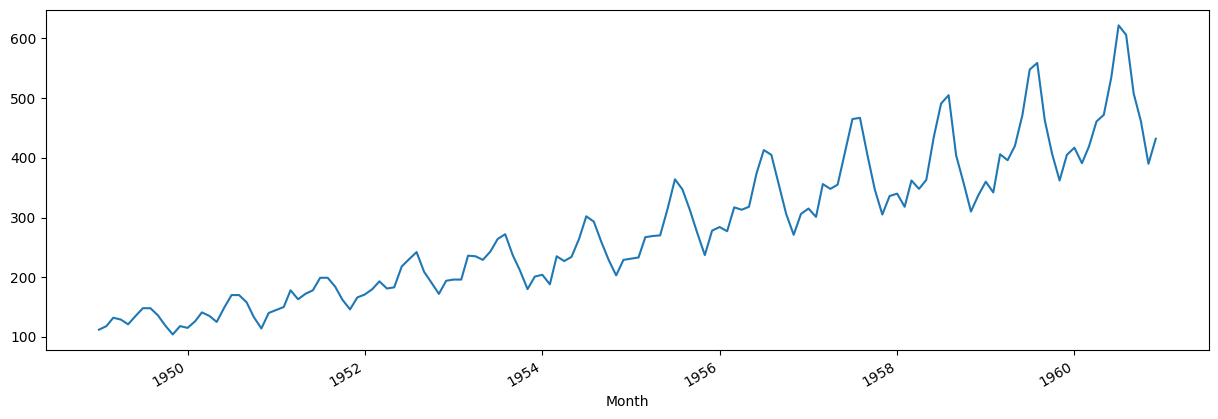

In [43]:
# time series with outliers removed
df2['y'].plot(figsize=(15, 5));

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


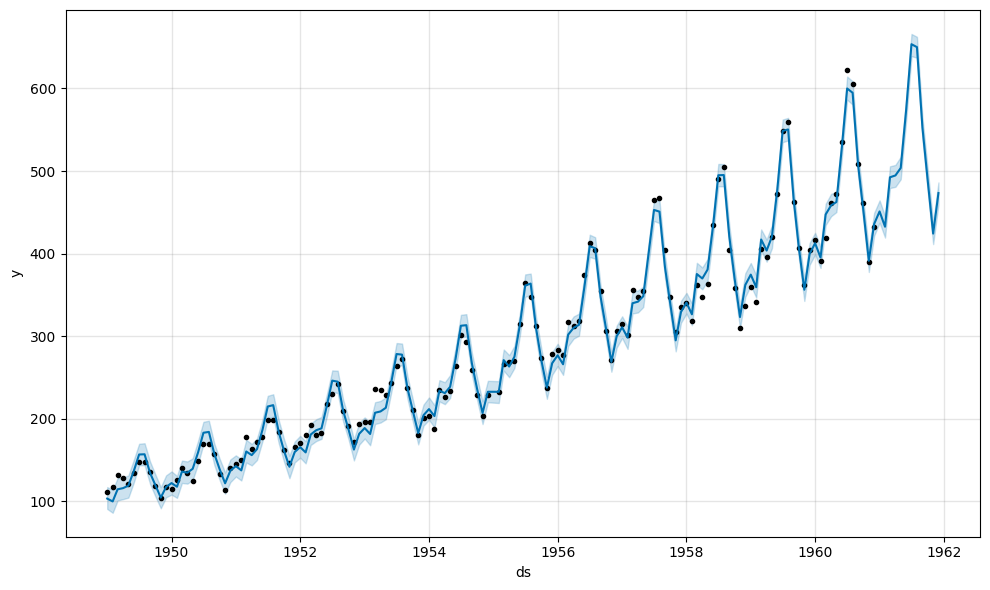

In [45]:
# no need to account for large deviations, hence prediction intervals are again small
m = Prophet(seasonality_mode='multiplicative')
m.fit(df2)
future = m.make_future_dataframe(periods=12, freq='MS')
forecast = m.predict(future)
m.plot(forecast);